In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass


In [2]:
from gemseo import configure_logger
from gemseo.algos.design_space import DesignSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo.disciplines.auto_py import AutoPyDiscipline
from numpy import array
from gemseo_oad_training.unit import convert_from

In [3]:
configure_logger()

<RootLogger root (INFO)>

**Création des disciplines**

In [4]:
l_disciplines = []
l_disciplines.append(AutoPyDiscipline(aerodynamic))
l_disciplines.append(AutoPyDiscipline(approach))
l_disciplines.append(AutoPyDiscipline(battery))
l_disciplines.append(AutoPyDiscipline(climb))
l_disciplines.append(AutoPyDiscipline(engine))
l_disciplines.append(AutoPyDiscipline(fuel_tank))
l_disciplines.append(AutoPyDiscipline(geometry))
l_disciplines.append(AutoPyDiscipline(mass))
l_disciplines.append(AutoPyDiscipline(mission))
l_disciplines.append(AutoPyDiscipline(operating_cost))
l_disciplines.append(AutoPyDiscipline(take_off))
l_disciplines.append(AutoPyDiscipline(total_mass))

**Création du desgin space**

In [5]:
class DesignSpacePB1(DesignSpace):
    def __init__(self):
        super().__init__(name="DSPB1")
        self.add_variable("slst", lower_bound=convert_from("kN",100), upper_bound=convert_from("kN",200), value=convert_from("kN",150.))
        self.add_variable("n_pax", lower_bound=120., upper_bound=180., value=150.)
        self.add_variable("area", lower_bound=convert_from("m2",100.), upper_bound=convert_from("m2",200.), value=convert_from("m2",180.))
        self.add_variable("ar", lower_bound=5, upper_bound=20., value=9.)


In [ ]:
design_space_pb1 = DesignSpacePB1()

In [7]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,150000,200000,float
n_pax,120,150,180,float
area,100,180,200,float
ar,5,9,20,float


In [33]:
scenario = MDOScenario(l_disciplines, "mtom", design_space_pb1, formulation_name="MDF")
scenario.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




In [9]:
scenario.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 14:35:04: *** Start MDOScenario execution ***
    INFO - 14:35:04: MDOScenario
    INFO - 14:35:04:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:35:04:    MDO formulation: MDF
    INFO - 14:35:04: Optimization problem:
    INFO - 14:35:04:    minimize mtom(slst, n_pax, area, ar)
    INFO - 14:35:04:    with respect to ar, area, n_pax, slst
    INFO - 14:35:04:    subject to constraints:
    INFO - 14:35:04:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 14:35:04:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 14:35:04:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 14:35:04:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 14:35:04:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 14:35:04:       fm(slst, n_pax, area, ar) >= 0
    INFO - 14:35:04:       fm(slst, n_pax, area, ar) <= 100
    INFO - 14:35:04:    over the design space:
    INFO 

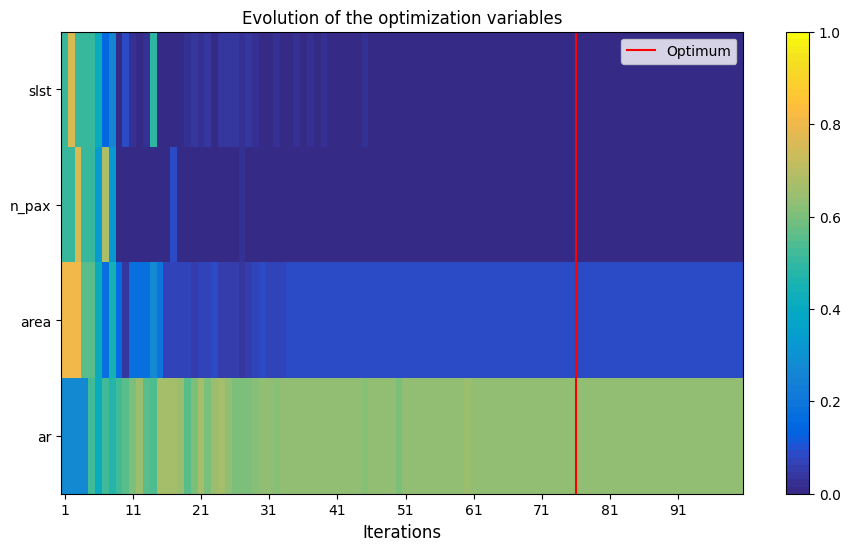

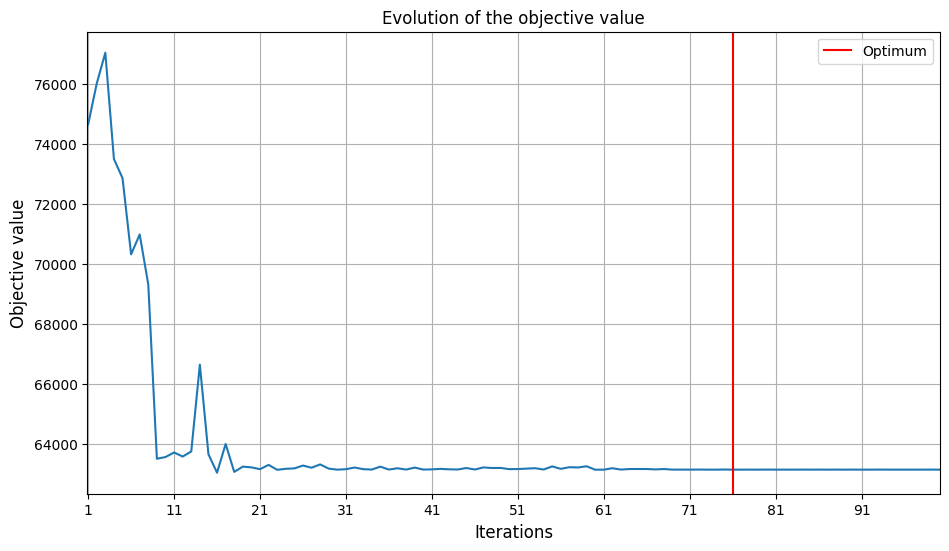

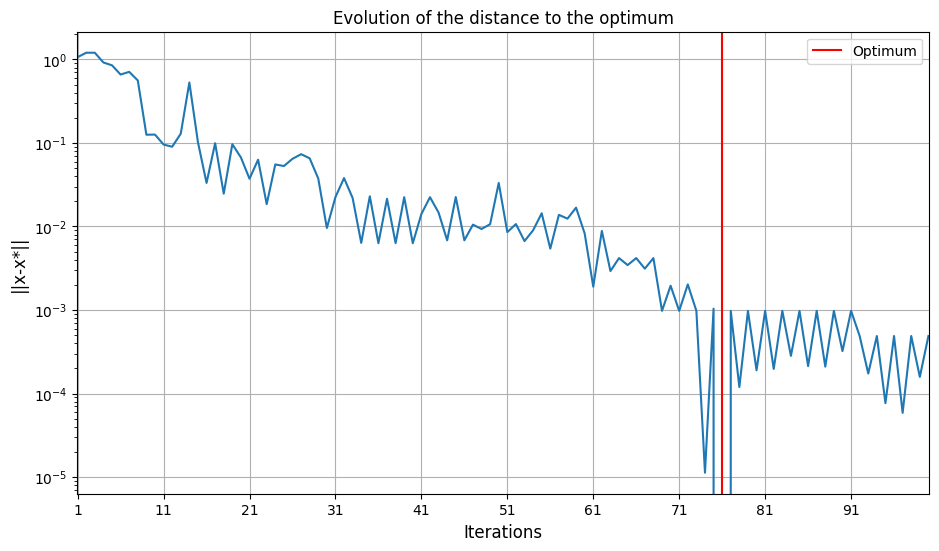

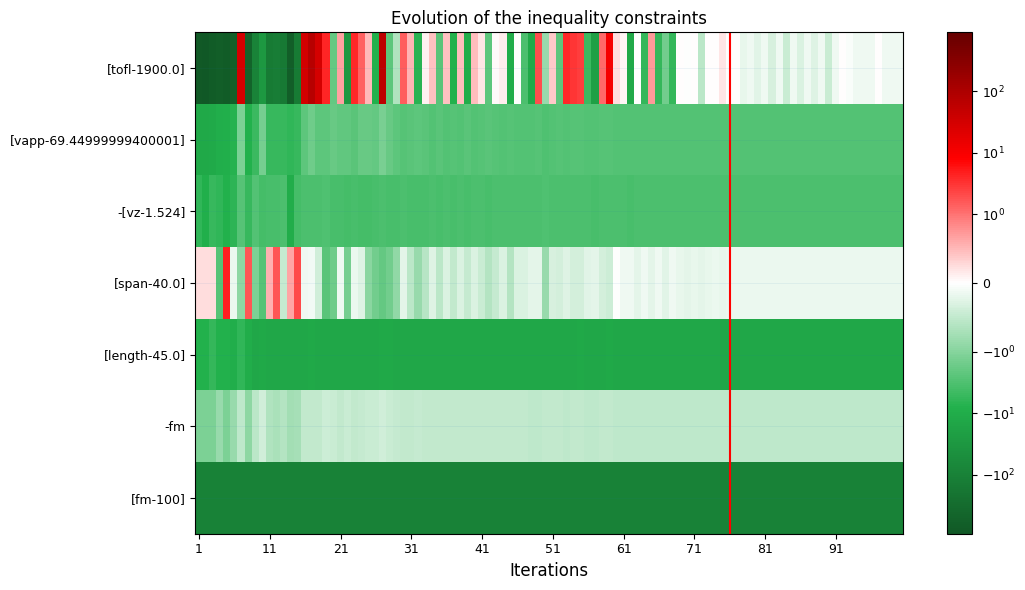

In [10]:
scenario.post_process(post_name="OptHistoryView", save=False, show=True)

Pour la suite : utiliser à la place des discipline s, smaple_discplines() -> "OT_OPT_LHS"  ou sobol ou halton
renvoye une surogate discpiline et remplacer dans MDO scenario la liste des discplines par la sugorate discpline

Surrogate

In [11]:
from gemseo.disciplines.surrogate import SurrogateDiscipline
from gemseo import sample_disciplines

In [35]:
training_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)

    INFO - 14:57:51: *** Start Sampling execution ***
    INFO - 14:57:51: Sampling
    INFO - 14:57:51:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:57:51:    MDO formulation: MDF
    INFO - 14:57:51: Running the algorithm OT_OPT_LHS:
    INFO - 14:57:51:    100%|██████████| 20/20 [00:00<00:00, 49.42 it/sec]
    INFO - 14:57:51: *** End Sampling execution (time: 0:00:00.424121) ***


In [13]:
test_dataset = sample_disciplines(l_disciplines, design_space_pb1, ["mtom", "tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_FULLFACT", n_samples=30)

    INFO - 14:35:08: *** Start Sampling execution ***
    INFO - 14:35:08: Sampling
    INFO - 14:35:08:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 14:35:08:    MDO formulation: MDF
    INFO - 14:35:08: Running the algorithm OT_FULLFACT:
    INFO - 14:35:09:    100%|██████████| 16/16 [00:00<00:00, 44.65 it/sec]s not exist; use 16 samples instead, i.e. the largest 4-th integer power less than 30.
    INFO - 14:35:09: *** End Sampling execution (time: 0:00:00.368053) ***


In [36]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [37]:
scenario_surrogate = MDOScenario([surrogate_discipline], "mtom", design_space_pb1, formulation_name="MDF")
scenario_surrogate.add_constraint("tofl", constraint_type="ineq", positive=False,value=convert_from("m", 1900))
scenario_surrogate.add_constraint("vapp", constraint_type="ineq", positive=False, value=convert_from("kt", 135))
scenario_surrogate.add_constraint("vz", constraint_type="ineq", positive=True, value=convert_from("ft/min", 300))
scenario_surrogate.add_constraint("span", constraint_type="ineq", positive=False, value=convert_from("m", 40))
scenario_surrogate.add_constraint("length", constraint_type="ineq", positive=False, value=convert_from("m", 45))
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=True, value=0)
scenario_surrogate.add_constraint("fm", constraint_type="ineq", positive=False, value=100)




 WARNING - 14:57:57: No coupling in MDA, switching chain_linearize to True.


In [38]:
scenario_surrogate.execute(algo_name="NLOPT_COBYLA", max_iter=100)

    INFO - 14:58:01: *** Start MDOScenario execution ***
    INFO - 14:58:01: MDOScenario
    INFO - 14:58:01:    Disciplines: RBF_Sampling
    INFO - 14:58:01:    MDO formulation: MDF
    INFO - 14:58:01: Optimization problem:
    INFO - 14:58:01:    minimize mtom(slst, n_pax, area, ar)
    INFO - 14:58:01:    with respect to ar, area, n_pax, slst
    INFO - 14:58:01:    subject to constraints:
    INFO - 14:58:01:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 14:58:01:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 14:58:01:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 14:58:01:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 14:58:01:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 14:58:01:       fm(slst, n_pax, area, ar) >= 0
    INFO - 14:58:01:       fm(slst, n_pax, area, ar) <= 100
    INFO - 14:58:01:    over the design space:
    INFO - 14:58:01:       +-------+-------------+-------------------+-------------+-------+
    INFO - 1

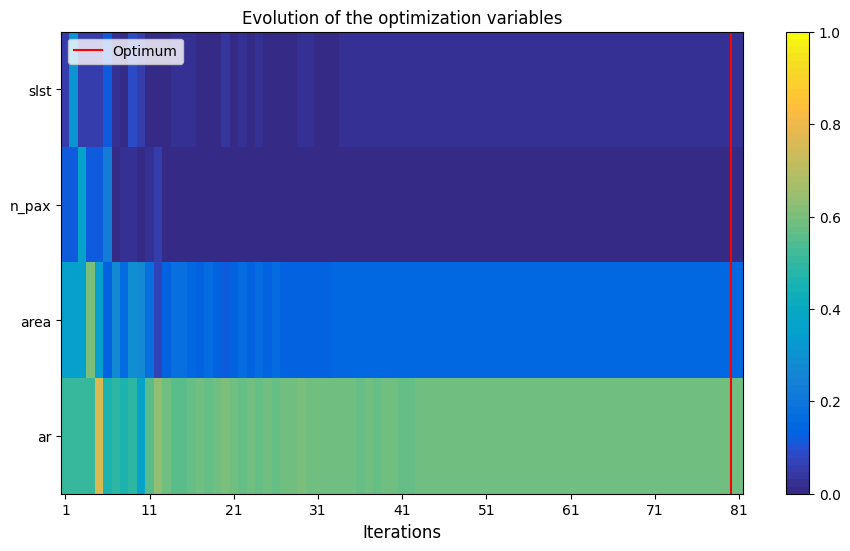

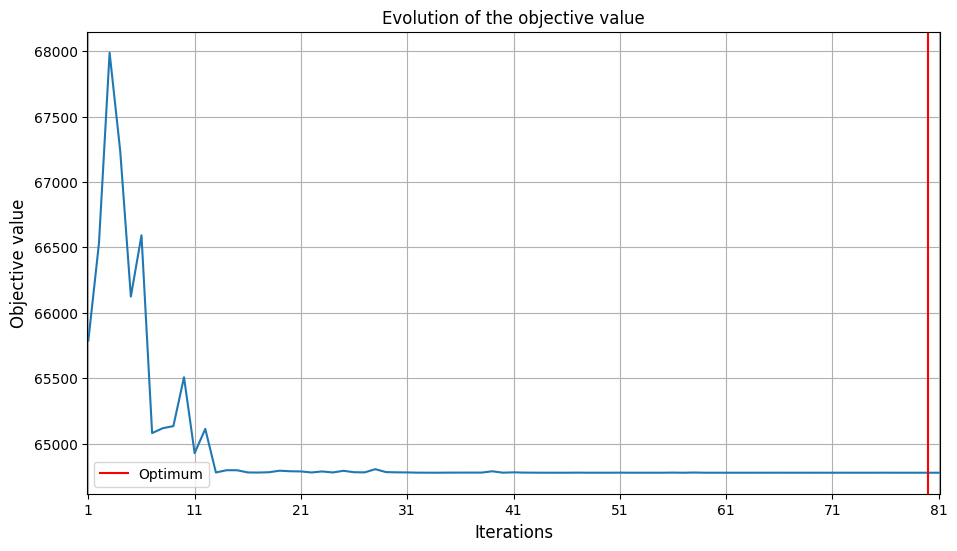

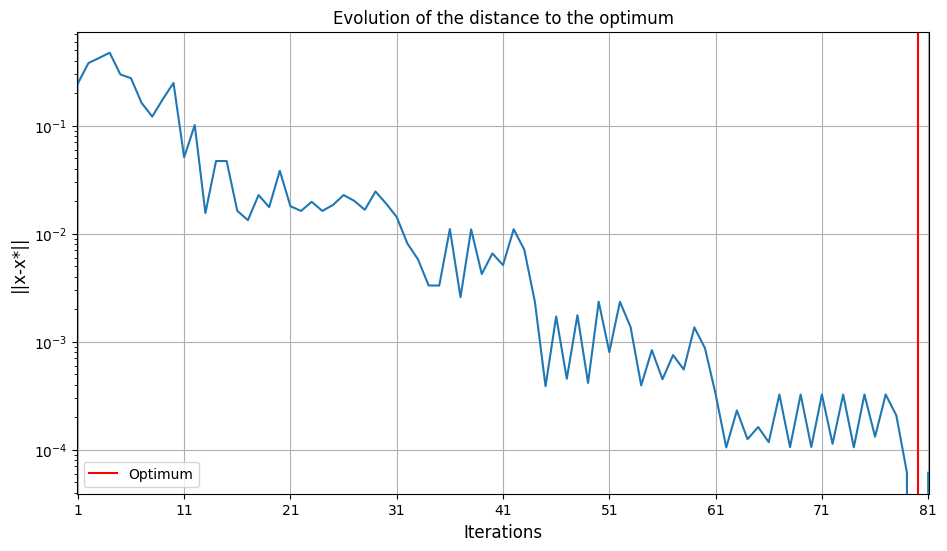

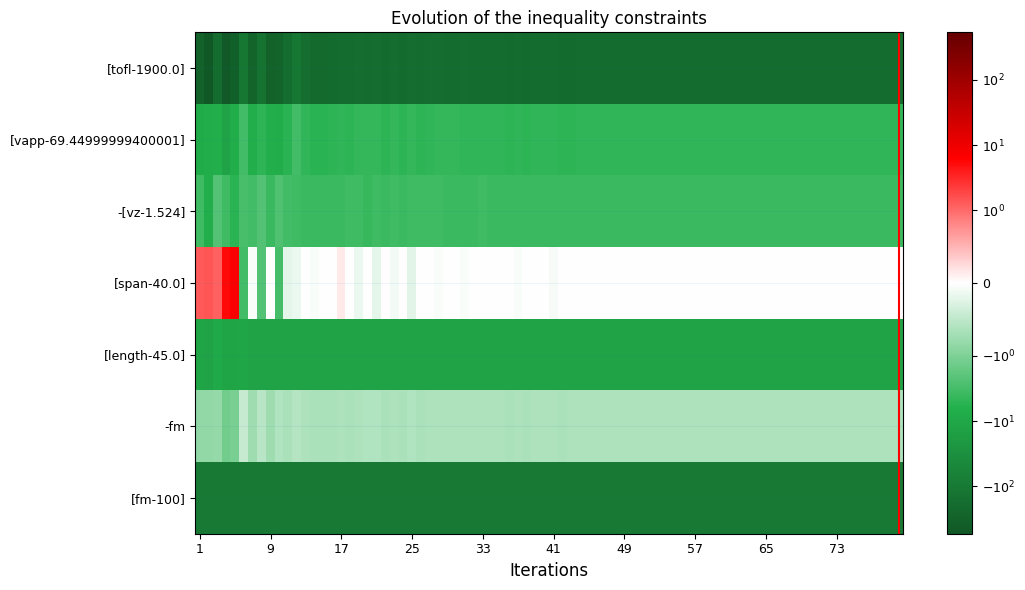

In [39]:
scenario_surrogate.post_process(post_name="OptHistoryView", save=False, show=True)

In [23]:
r2 = surrogate_discipline.get_error_measure("R2Measure")

In [24]:
r2.compute_cross_validation_measure(as_dict=True)

{'fm': array([0.98605822]),
 'length': array([0.99251924]),
 'mtom': array([0.97396249]),
 'span': array([0.98681986]),
 'tofl': array([0.96271938]),
 'vapp': array([0.97981084]),
 'vz': array([0.96650881])}

In [25]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.95011788]),
 'length': array([0.97150656]),
 'mtom': array([0.88579027]),
 'span': array([0.96297641]),
 'tofl': array([0.89607181]),
 'vapp': array([0.96435412]),
 'vz': array([0.94968117])}

In [26]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")

In [27]:
rmse.compute_learning_measure(as_dict=True)

{'fm': array([8.29631752e-16]),
 'length': array([4.76646557e-15]),
 'mtom': array([771.83823538]),
 'span': array([1.32096946e-14]),
 'tofl': array([5.75776415e-13]),
 'vapp': array([8.55606755e-15]),
 'vz': array([9.21299497e-15])}

In [58]:
design_space_pb1

Name,Lower bound,Value,Upper bound,Type
slst,100000,101869.9193764449,200000,float
n_pax,120,120,180,float
area,100,114.5536418804059,200,float
ar,5,13.73396340748999,20,float


In [53]:
#Vérification si le x optimal vérifie les contraintes (possible que non avec le model surrogate)
scenario.execute(algo_name="CustomDOE", samples=array([[101869.9193764449, 120, 114.5536418804059, 13.73396340748999]]))

    INFO - 15:02:37: *** Start MDOScenario execution ***
    INFO - 15:02:37: MDOScenario
    INFO - 15:02:37:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 15:02:37:    MDO formulation: MDF
    INFO - 15:02:37: Optimization problem:
    INFO - 15:02:37:    minimize mtom(slst, n_pax, area, ar)
    INFO - 15:02:37:    with respect to ar, area, n_pax, slst
    INFO - 15:02:37:    subject to constraints:
    INFO - 15:02:37:       tofl(slst, n_pax, area, ar) <= 1900.0
    INFO - 15:02:37:       vapp(slst, n_pax, area, ar) <= 69.44999999400001
    INFO - 15:02:37:       vz(slst, n_pax, area, ar) >= 1.524
    INFO - 15:02:37:       span(slst, n_pax, area, ar) <= 40.0
    INFO - 15:02:37:       length(slst, n_pax, area, ar) <= 45.0
    INFO - 15:02:37:       fm(slst, n_pax, area, ar) >= 0
    INFO - 15:02:37:       fm(slst, n_pax, area, ar) <= 100
    INFO - 15:02:37:    over the design space:
    INFO 